# **<center> Modeling: Kaggle Competition </center>**
![Immune](https://i.imgur.com/0TSSaqL.png)  

In [2]:
%load_ext autoreload
%autoreload 2

In [51]:
import os
import pandas as pd
import json
import pickle
from xgboost  import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from paths import RAW_DIR, PROCESSED_DIR, SUBMISSIONS_DIR, MODELS_DIR
from functions import compute_metrics, plot_errors
from transformers import ExtractDataNeighborhood, FillNA, RentPriceTransformer
import warnings
from datetime import datetime

warnings.simplefilter(action='ignore', category=FutureWarning)

raw_train_df = pd.read_csv(os.path.join(RAW_DIR, 'train.csv'))
raw_predict_df = pd.read_csv(os.path.join(RAW_DIR, 'test.csv'))

In [5]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17448 entries, 0 to 17447
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            17448 non-null  int64  
 1   title                         17448 non-null  object 
 2   subtitle                      17448 non-null  object 
 3   sq_mt_built                   17348 non-null  float64
 4   sq_mt_useful                  6575 non-null   float64
 5   n_rooms                       17448 non-null  int64  
 6   n_bathrooms                   17434 non-null  float64
 7   n_floors                      1163 non-null   float64
 8   sq_mt_allotment               1146 non-null   float64
 9   latitude                      0 non-null      float64
 10  longitude                     0 non-null      float64
 11  raw_address                   13056 non-null  object 
 12  is_exact_address_hidden       17448 non-null  bool   
 13  s

In [6]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(raw_train_df, raw_train_df['buy_price_by_area'], test_size=0.2, random_state=42)

In [7]:
# Features for one-hot encoding
categorical_columns = ['floor', 'house_type_id', 'energy_certificate']

# Features for filling NA with False
fill_na_false_columns = [
    'has_lift', 
    'is_new_development', 
    'has_central_heating', 
    'has_ac', 
    'has_parking', 
    'is_exterior', 
    'has_garden', 
    'has_pool', 
    'has_terrace', 
    'has_balcony', 
    'has_storage_room', 
    'has_green_zones', 
    'has_fitted_wardrobes']

# Features for filling NA with True
fill_na_true_columns = [
    'is_parking_included_in_price',
    'is_renewal_needed'
]

# Features for standard scaling
numerical_columns = ['sq_mt_built', 'n_rooms', 'n_bathrooms']

# Define preprocessing transformers for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardize numerical features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),
        ('rent_price', RentPriceTransformer(), ['rent_price']),
        ('loc_info', ExtractDataNeighborhood(), ['neighborhood_id']),
        ('cat_bool', FillNA(fill_na_false_columns, type_fill='False'), fill_na_false_columns),
        ('cat_bool_2', FillNA(fill_na_true_columns, type_fill='True'), fill_na_true_columns),
        ('cat', 'passthrough', categorical_columns)
    ],
    remainder='drop')

feature_eng = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, slice(0, 5)),
        ('cat', categorical_transformer, slice(5, 26)),
    ],
    remainder='drop')


etl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_eng', feature_eng),
    ])

In [10]:
etl_pipeline.fit(X_train, y_train)

# Transform the data
train_transformed = pd.DataFrame.sparse.from_spmatrix(etl_pipeline.transform(X_train), columns=etl_pipeline.get_feature_names_out())
train_transformed['buy_price_by_area'] = y_train.values
test_transformed = pd.DataFrame.sparse.from_spmatrix(etl_pipeline.transform(X_test), columns=etl_pipeline.get_feature_names_out())
test_transformed['buy_price_by_area'] = y_test.values

# Save in csv format
train_transformed.to_csv(os.path.join(PROCESSED_DIR, 'train.csv'), index=False)
test_transformed.to_csv(os.path.join(PROCESSED_DIR, 'test.csv'), index=False)


# # Object columns to categorical to avoid problems with xgboost
# object_cols = X_train_transformed.select_dtypes(include=['object']).columns
# X_train_transformed[object_cols] = X_train_transformed[object_cols].astype('category')
# X_test_transformed[object_cols] = X_test_transformed[object_cols].astype('category')

# X_train_transformed.info()

# # # Save in parquet format
# pd.DataFrame(X_train_transformed).to_parquet(os.path.join(PROCESSED_DIR, 'train.parquet'))
# pd.DataFrame(X_test_transformed).to_parquet(os.path.join(PROCESSED_DIR, 'test.parquet'))

In [95]:
# Create the XGBoost model
xgb_model = XGBRegressor()

params = {
    'booster': ['gbtree'],
    'importance_type': ['gain'],
    'learning_rate': [0.1],
    'max_depth': [6, 7],
    'n_estimators': [500],
    'n_jobs':[ -1],
    'objective': ['reg:squarederror'],
    'random_state': [1234],
    'eval_metric':['mape']
    }

grid_search = GridSearchCV(xgb_model, params, cv=5, n_jobs=-1, verbose=1)

# Import the data
X_train = train_transformed.drop(columns=['buy_price_by_area'])
y_train = train_transformed['buy_price_by_area']
X_test = test_transformed.drop(columns=['buy_price_by_area'])
y_test = test_transformed['buy_price_by_area']

# Fit the pipeline to the training data
grid_search.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)])

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

[0]	validation_0-mape:0.89594	validation_1-mape:0.89606
[0]	validation_0-mape:0.89607	validation_1-mape:0.89592
[0]	validation_0-mape:0.89619	validation_1-mape:0.89611
[0]	validation_0-mape:0.89610	validation_1-mape:0.89611
[0]	validation_0-mape:0.89591	validation_1-mape:0.89571
[1]	validation_0-mape:0.80240	validation_1-mape:0.80241
[1]	validation_0-mape:0.80257	validation_1-mape:0.80215
[1]	validation_0-mape:0.80272	validation_1-mape:0.80258
[0]	validation_0-mape:0.89682	validation_1-mape:0.89668
[1]	validation_0-mape:0.80270	validation_1-mape:0.80288
[1]	validation_0-mape:0.80258	validation_1-mape:0.80261
[2]	validation_0-mape:0.71872	validation_1-mape:0.71848
[2]	validation_0-mape:0.71827	validation_1-mape:0.71772


/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Us

[1]	validation_0-mape:0.80431	validation_1-mape:0.80424
[2]	validation_0-mape:0.71879	validation_1-mape:0.71830
[0]	validation_0-mape:0.89672	validation_1-mape:0.89667
[2]	validation_0-mape:0.71862	validation_1-mape:0.71874
[3]	validation_0-mape:0.64330	validation_1-mape:0.64293
[0]	validation_0-mape:0.89687	validation_1-mape:0.89649
[2]	validation_0-mape:0.71848	validation_1-mape:0.71839
[3]	validation_0-mape:0.64277	validation_1-mape:0.64214
[2]	validation_0-mape:0.72094	validation_1-mape:0.72061
[1]	validation_0-mape:0.80396	validation_1-mape:0.80371
[3]	validation_0-mape:0.64289	validation_1-mape:0.64249[3]	validation_0-mape:0.64321	validation_1-mape:0.64269

[4]	validation_0-mape:0.57570	validation_1-mape:0.57506
[3]	validation_0-mape:0.64313	validation_1-mape:0.64286
[1]	validation_0-mape:0.80442	validation_1-mape:0.80402
[4]	validation_0-mape:0.57502	validation_1-mape:0.57412
[4]	validation_0-mape:0.57548	validation_1-mape:0.57527
[2]	validation_0-mape:0.72059	validation_1-mape:

/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

[499]	validation_0-mape:0.03101	validation_1-mape:0.05447
[427]	validation_0-mape:0.02597	validation_1-mape:0.05385
[428]	validation_0-mape:0.02524	validation_1-mape:0.05371
[481]	validation_0-mape:0.03126	validation_1-mape:0.05572
[491]	validation_0-mape:0.03211	validation_1-mape:0.05539
[498]	validation_0-mape:0.03011	validation_1-mape:0.05518
[432]	validation_0-mape:0.02525	validation_1-mape:0.05275
[428]	validation_0-mape:0.02592	validation_1-mape:0.05381
[482]	validation_0-mape:0.03126	validation_1-mape:0.05572
[429]	validation_0-mape:0.02521	validation_1-mape:0.05372
[492]	validation_0-mape:0.03206	validation_1-mape:0.05538
[499]	validation_0-mape:0.03009	validation_1-mape:0.05519
[433]	validation_0-mape:0.02522	validation_1-mape:0.05274
[429]	validation_0-mape:0.02588	validation_1-mape:0.05383
[483]	validation_0-mape:0.03120	validation_1-mape:0.05568
[493]	validation_0-mape:0.03202	validation_1-mape:0.05534
[434]	validation_0-mape:0.02522	validation_1-mape:0.05274
[430]	validati

/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categoric

[430]	validation_0-mape:0.02586	validation_1-mape:0.05382
[484]	validation_0-mape:0.03116	validation_1-mape:0.05566
[494]	validation_0-mape:0.03200	validation_1-mape:0.05534
[431]	validation_0-mape:0.02512	validation_1-mape:0.05371
[431]	validation_0-mape:0.02582	validation_1-mape:0.05381
[435]	validation_0-mape:0.02520	validation_1-mape:0.05273
[495]	validation_0-mape:0.03199	validation_1-mape:0.05534
[0]	validation_0-mape:0.89690	validation_1-mape:0.89687
[485]	validation_0-mape:0.03113	validation_1-mape:0.05564
[436]	validation_0-mape:0.02519	validation_1-mape:0.05271
[432]	validation_0-mape:0.02508	validation_1-mape:0.05368
[486]	validation_0-mape:0.03109	validation_1-mape:0.05563
[432]	validation_0-mape:0.02579	validation_1-mape:0.05378
[496]	validation_0-mape:0.03197	validation_1-mape:0.05533
[1]	validation_0-mape:0.80412	validation_1-mape:0.80397


/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[0]	validation_0-mape:0.89677	validation_1-mape:0.89656
[487]	validation_0-mape:0.03105	validation_1-mape:0.05562
[437]	validation_0-mape:0.02515	validation_1-mape:0.05270
[433]	validation_0-mape:0.02505	validation_1-mape:0.05369
[433]	validation_0-mape:0.02575	validation_1-mape:0.05378
[2]	validation_0-mape:0.72095	validation_1-mape:0.72034
[497]	validation_0-mape:0.03195	validation_1-mape:0.05531
[488]	validation_0-mape:0.03103	validation_1-mape:0.05563
[498]	validation_0-mape:0.03192	validation_1-mape:0.05528
[438]	validation_0-mape:0.02514	validation_1-mape:0.05270
[434]	validation_0-mape:0.02500	validation_1-mape:0.05367
[434]	validation_0-mape:0.02572	validation_1-mape:0.05375
[1]	validation_0-mape:0.80431	validation_1-mape:0.80401
[3]	validation_0-mape:0.64629	validation_1-mape:0.64533
[499]	validation_0-mape:0.03190	validation_1-mape:0.05527
[489]	validation_0-mape:0.03097	validation_1-mape:0.05558
[4]	validation_0-mape:0.57914	validation_1-mape:0.57800
[439]	validation_0-mape:

/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

[436]	validation_0-mape:0.02494	validation_1-mape:0.05367
[3]	validation_0-mape:0.64591	validation_1-mape:0.64526
[436]	validation_0-mape:0.02568	validation_1-mape:0.05376
[5]	validation_0-mape:0.51853	validation_1-mape:0.51669
[491]	validation_0-mape:0.03089	validation_1-mape:0.05557
[441]	validation_0-mape:0.02512	validation_1-mape:0.05271
[437]	validation_0-mape:0.02567	validation_1-mape:0.05377
[437]	validation_0-mape:0.02491	validation_1-mape:0.05368
[6]	validation_0-mape:0.46428	validation_1-mape:0.46256
[4]	validation_0-mape:0.57859	validation_1-mape:0.57793
[492]	validation_0-mape:0.03087	validation_1-mape:0.05555
[438]	validation_0-mape:0.02563	validation_1-mape:0.05374
[442]	validation_0-mape:0.02508	validation_1-mape:0.05269
[438]	validation_0-mape:0.02489	validation_1-mape:0.05368
[5]	validation_0-mape:0.51816	validation_1-mape:0.51717
[493]	validation_0-mape:0.03081	validation_1-mape:0.05552
[7]	validation_0-mape:0.41608	validation_1-mape:0.41406
[443]	validation_0-mape:0.

/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

[13]	validation_0-mape:0.22264	validation_1-mape:0.22168
[445]	validation_0-mape:0.02467	validation_1-mape:0.05366
[445]	validation_0-mape:0.02542	validation_1-mape:0.05370
[12]	validation_0-mape:0.24480	validation_1-mape:0.24400
[449]	validation_0-mape:0.02493	validation_1-mape:0.05266
[14]	validation_0-mape:0.20247	validation_1-mape:0.20201
[446]	validation_0-mape:0.02540	validation_1-mape:0.05371
[446]	validation_0-mape:0.02464	validation_1-mape:0.05364
[450]	validation_0-mape:0.02491	validation_1-mape:0.05265
[13]	validation_0-mape:0.22191	validation_1-mape:0.22156
[15]	validation_0-mape:0.18464	validation_1-mape:0.18487
[447]	validation_0-mape:0.02540	validation_1-mape:0.05371
[451]	validation_0-mape:0.02490	validation_1-mape:0.05266
[447]	validation_0-mape:0.02461	validation_1-mape:0.05363
[14]	validation_0-mape:0.20188	validation_1-mape:0.20213
[16]	validation_0-mape:0.16924	validation_1-mape:0.17022
[448]	validation_0-mape:0.02457	validation_1-mape:0.05362
[452]	validation_0-ma

/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

[497]	validation_0-mape:0.02355	validation_1-mape:0.05335
[498]	validation_0-mape:0.02404	validation_1-mape:0.05340
[67]	validation_0-mape:0.05323	validation_1-mape:0.06524
[65]	validation_0-mape:0.05396	validation_1-mape:0.06697
[68]	validation_0-mape:0.05310	validation_1-mape:0.06519
[498]	validation_0-mape:0.02354	validation_1-mape:0.05335
[499]	validation_0-mape:0.02400	validation_1-mape:0.05339
[66]	validation_0-mape:0.05369	validation_1-mape:0.06691
[69]	validation_0-mape:0.05305	validation_1-mape:0.06520
[499]	validation_0-mape:0.02351	validation_1-mape:0.05335
[67]	validation_0-mape:0.05358	validation_1-mape:0.06685
[70]	validation_0-mape:0.05292	validation_1-mape:0.06508
[68]	validation_0-mape:0.05327	validation_1-mape:0.06667
[71]	validation_0-mape:0.05247	validation_1-mape:0.06470
[69]	validation_0-mape:0.05287	validation_1-mape:0.06641
[72]	validation_0-mape:0.05238	validation_1-mape:0.06470


/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


[70]	validation_0-mape:0.05249	validation_1-mape:0.06624
[73]	validation_0-mape:0.05203	validation_1-mape:0.06447
[71]	validation_0-mape:0.05228	validation_1-mape:0.06607
[74]	validation_0-mape:0.05197	validation_1-mape:0.06450
[72]	validation_0-mape:0.05209	validation_1-mape:0.06594
[75]	validation_0-mape:0.05177	validation_1-mape:0.06427
[73]	validation_0-mape:0.05188	validation_1-mape:0.06572
[76]	validation_0-mape:0.05170	validation_1-mape:0.06425
[74]	validation_0-mape:0.05167	validation_1-mape:0.06551
[77]	validation_0-mape:0.05166	validation_1-mape:0.06427
[75]	validation_0-mape:0.05142	validation_1-mape:0.06532
[78]	validation_0-mape:0.05134	validation_1-mape:0.06398
[76]	validation_0-mape:0.05133	validation_1-mape:0.06530
[79]	validation_0-mape:0.05089	validation_1-mape:0.06362
[77]	validation_0-mape:0.05108	validation_1-mape:0.06522
[80]	validation_0-mape:0.05083	validation_1-mape:0.06361
[78]	validation_0-mape:0.05091	validation_1-mape:0.06518
[81]	validation_0-mape:0.05051	

/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/eric/Documents/Projects/kaggle_test/env/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

[498]	validation_0-mape:0.02420	validation_1-mape:0.05283
[499]	validation_0-mape:0.02417	validation_1-mape:0.05282
[0]	validation_0-mape:0.89671	validation_1-mape:0.89677
[1]	validation_0-mape:0.80399	validation_1-mape:0.80399
[2]	validation_0-mape:0.72087	validation_1-mape:0.72067
[3]	validation_0-mape:0.64628	validation_1-mape:0.64596
[4]	validation_0-mape:0.57889	validation_1-mape:0.57780
[5]	validation_0-mape:0.51840	validation_1-mape:0.51680
[6]	validation_0-mape:0.46428	validation_1-mape:0.46273
[7]	validation_0-mape:0.41588	validation_1-mape:0.41439
[8]	validation_0-mape:0.37306	validation_1-mape:0.37142
[9]	validation_0-mape:0.33490	validation_1-mape:0.33313
[10]	validation_0-mape:0.30105	validation_1-mape:0.29954
[11]	validation_0-mape:0.27125	validation_1-mape:0.26990
[12]	validation_0-mape:0.24525	validation_1-mape:0.24410
[13]	validation_0-mape:0.22220	validation_1-mape:0.22149
[14]	validation_0-mape:0.20217	validation_1-mape:0.20204
[15]	validation_0-mape:0.18433	validati

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree'], 'eval_metric': ['mape'],
                         'importance_type': ['gain'], 'learning_rate': [0.1],
                         'max_depth': [6, 7], 'n_estimators': [500],
                         'n_jobs': [-1], 'objective': ['reg:squarederror'],
                         'random_state': [1234]},
             verbose=1)

In [96]:
model = grid_search.best_estimator_

# Save the model in pickle file
model_name = 'xgboost_model_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '.pkl'
model_path = os.path.join(MODELS_DIR, model_name)

pickle.dump(model, open(model_path, 'wb'))

model

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type='gain',
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=1234, ...)

In [97]:
# Make predictions on the test set
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# Eval Model (there is no need to cross-validate because we already did it in the grid search)
metrics = compute_metrics(grid_search, y_test, y_pred, y_train, y_train_pred)


Train/Test split results:
GridSearchCV r2 is 0.913
GridSearchCV mean_squared_error is 315282.282
GridSearchCV mean_absolute_error is 238.805
GridSearchCV mape test is 0.051
GridSearchCV mape train is 0.018


In [98]:
# Save metrics and model parameters in json format
metrics_names = ('r2', 'mse', 'mae', 'mape_test', 'mape_train')

metrics_dict = {metric_name: metric_value for metric_name, metric_value in zip(metrics_names, metrics)}

to_save = {
    'model_fit_params': params,
    'model_params': model.get_params(),
    'metrics': metrics_dict
    }

with open(os.path.join(MODELS_DIR, f'metrics_{model.__class__.__name__}_{round(metrics_dict["mape_test"], 4)}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.json'), 'w') as f:
    json.dump(to_save, f)

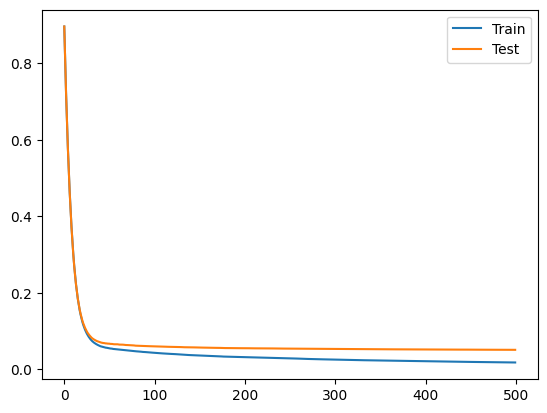

In [99]:
plot_errors(model, 'mape')

In [100]:
pd.DataFrame(zip(model.get_booster().feature_names ,model.feature_importances_)).sort_values(1,ascending=False).head(10)

,0,1
4,num__loc_info__neighborhood_mean_price,0.308759
26,cat__cat_bool__is_new_development_True,0.119052
3,num__rent_price__rent_price,0.041453
63,cat__cat__house_type_id_HouseType 5: Áticos,0.029007
39,cat__cat_bool_2__is_renewal_needed_True,0.028850
47,cat__cat__floor_8,0.028493
25,cat__cat_bool__has_lift_True,0.025279
0,num__num__sq_mt_built,0.019614
32,cat__cat_bool__has_pool_True,0.018334
60,cat__cat__house_type_id_HouseType 1: Pisos,0.016511


## KAGGLE SUBMISSION

In [101]:
def eval_best_model(final_model, valid_df):

    Id_aux = valid_df[['id']]

    X_valid = etl_pipeline.transform(valid_df)
    y_valid_pred = final_model.predict(X_valid)

    submission = pd.DataFrame({'id': Id_aux['id'],
                               'buy_price_by_area': y_valid_pred})
    return (submission)

In [102]:
submission = eval_best_model(model, raw_predict_df)

submission.to_csv(os.path.join(SUBMISSIONS_DIR, f'submission_{model.__class__.__name__}_{round(metrics_dict["mape_test"], 4)}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'), index=False)